In [247]:
import optuna
from lightgbm import plot_importance, LGBMRegressor
import getFamaFrenchFactors as gff
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [248]:
stocks_df = pd.read_csv('../../data/market_data/sp500/sp500_stocks.csv')
df = stocks_df.pivot(
    index='Date', columns='Symbol', values='Adj Close')

df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

df.head()

Symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.122227,4.496877,6.470741,NaN,NaN,18.952162,7.994444,32.212460,37.090000,23.694084,...,52.883579,9.905468,41.963718,12.918809,43.185623,NaN,19.158102,52.587051,28.670000,NaN
2010-01-05,19.903643,5.005957,6.481929,NaN,NaN,18.799042,7.967778,32.411549,37.700001,23.656675,...,52.765053,10.115747,44.515926,12.765595,43.354244,NaN,19.092571,54.251759,28.620001,NaN
2010-01-06,19.832930,4.798554,6.378825,NaN,NaN,18.903446,7.933333,32.756096,37.619999,23.611784,...,53.614498,10.003899,43.932011,12.790110,43.728970,NaN,18.956089,54.234219,28.400000,NaN
2010-01-07,19.807215,4.939964,6.367033,NaN,NaN,19.060045,7.886667,32.725471,36.889999,23.424749,...,53.456463,9.959157,44.870213,12.734954,43.591564,NaN,18.950626,55.478374,27.690001,NaN
2010-01-08,19.800785,4.845691,6.409364,NaN,NaN,19.157482,7.871111,32.595306,36.689999,23.559416,...,53.397202,9.867439,44.548744,12.741086,43.416687,NaN,18.956089,54.313072,27.600000,NaN


In [249]:
tickers = ['AAPL']

In [250]:
ff5 = pd.DataFrame(gff.famaFrench5Factor(frequency='m'))
ff5.head()

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1,1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027


In [251]:
fff = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

N_lags = 10

for f in fff:
  for i in range(1, N_lags):
    ff5[f'{f}_{i}L'] = ff5[f].shift(-i)

In [252]:
mon = pd.DataFrame(df[tickers[0]]).resample('ME').last()
mon_rets = mon.pct_change().dropna()

factors = ff5.rename(columns={'date_ff_factors': 'Date'})
factors_0 = pd.merge(mon_rets, factors, on='Date', how='left')
factors_0 = factors_0.dropna()

Y = (factors_0[tickers[0]] - factors_0['RF'])
X = factors_0.drop(
    columns=['RF', tickers[0]]).set_index('Date')

In [253]:
top15features_stable = ['RMW_5L',
                        'RMW_2L',
                        'SMB_6L',
                        'CMA_9L',
                        'SMB_2L',
                        'HML_5L',
                        'Mkt-RF_7L',
                        'CMA_4L',
                        'CMA_6L',
                        'RMW_6L',
                        'CMA_8L',
                        'Mkt-RF_2L',
                        'CMA',
                        'RMW',
                        'Mkt-RF']

In [254]:

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False)

## Train MLNN

In [255]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [256]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

/Users/daniel/Desktop/Projects/DS/cc/Fama-French-models/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/daniel/Desktop/Projects/DS/cc/Fama-French-models/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/daniel/Desktop/Projects/DS/cc/Fama-French-models/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([33])) that is different to the input size

Epoch 0: train RMSE 0.1098, test RMSE 0.1166
Epoch 0: train RMSE 0.1054, test RMSE 0.1119
Epoch 0: train RMSE 0.0921, test RMSE 0.0977
Epoch 0: train RMSE 0.0831, test RMSE 0.0873
Epoch 0: train RMSE 0.0790, test RMSE 0.0816
Epoch 0: train RMSE 0.0789, test RMSE 0.0800
Epoch 0: train RMSE 0.0811, test RMSE 0.0809
Epoch 0: train RMSE 0.0852, test RMSE 0.0838
Epoch 0: train RMSE 0.0851, test RMSE 0.0837
Epoch 0: train RMSE 0.0853, test RMSE 0.0839
Epoch 0: train RMSE 0.0850, test RMSE 0.0836
Epoch 0: train RMSE 0.0815, test RMSE 0.0811
Epoch 0: train RMSE 0.0787, test RMSE 0.0802
Epoch 0: train RMSE 0.0792, test RMSE 0.0819
Epoch 0: train RMSE 0.0811, test RMSE 0.0848
Epoch 0: train RMSE 0.0840, test RMSE 0.0884
Epoch 0: train RMSE 0.0842, test RMSE 0.0887
Epoch 0: train RMSE 0.0817, test RMSE 0.0855
Epoch 0: train RMSE 0.0795, test RMSE 0.0824
Epoch 0: train RMSE 0.0786, test RMSE 0.0806
Epoch 0: train RMSE 0.0791, test RMSE 0.0800
Epoch 0: train RMSE 0.0806, test RMSE 0.0806
Epoch 0: t

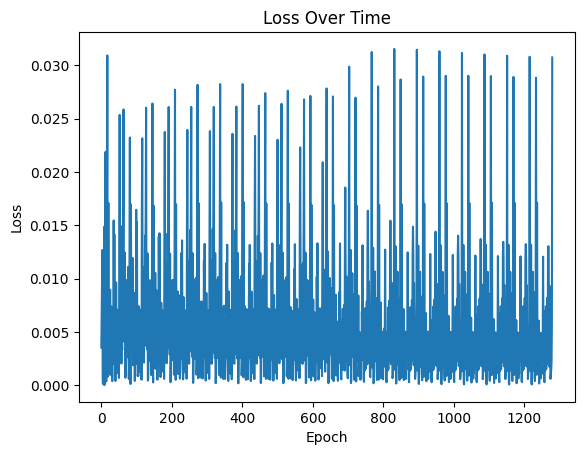

In [257]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score


class MultiLayerNN(nn.Module):
    def __init__(self, input_size):
        super(MultiLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 4)
        self.layer2 = nn.Linear(4, 8)
        self.layer3 = nn.Linear(8, 32)
        self.layer4 = nn.Linear(32, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        x = torch.tanh(self.layer4(x))
        x = torch.tanh(self.layer5(x))
        x = torch.tanh(self.layer6(x))
        x = self.output_layer(x)
        return x


# Initialize the model
input_size = X_train_tensor.shape[1]
model = MultiLayerNN(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
num_epochs = 20
batch_size = 2
for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                y_pred = model(X_train_tensor)
                train_rmse = np.sqrt(criterion(y_pred, y_train_tensor))
                y_pred = model(X_test_tensor)
                test_rmse = np.sqrt(criterion(y_pred, y_test_tensor))
            print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Note: This is a basic example. Depending on your dataset and problem, you might need to adjust parameters like learning rate, batch size, etc.

# r2_score(targets.detach().numpy(), outputs.detach().numpy())

# Plotting the loss values
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()

In [258]:
r2_score(targets.detach().numpy(), outputs.detach().numpy())

0.3946268474904233

In [259]:
torch.save(model, 'model.pth')